# Genomes Analysis and Regularization

In [1]:
import pickle
import neat
import graphviz
import matplotlib.pyplot as plt

## Load genomes

In [4]:
path = "../results/driftoku_neat_800_100_300_5_30_1/best_genome.pkl"
with open(path, "rb") as f:
    winner1 = pickle.load(f)
path = "../results/driftoku_neat_800_100_300_5_30_2/best_genome.pkl"
with open(path, "rb") as f:
    winner2 = pickle.load(f)

In [5]:
# load config
config_path = "../config-feedforward.txt"
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)

## Visualize genomes

In [6]:
def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    # if graphviz is None:
    #     warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
    #     return

    # If requested, use a copy of the genome which omits all components that won't affect the output.
    if prune_unused:
        genome = genome.get_pruned_copy(config.genome_config)

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled', 'shape': 'box', 'fillcolor': node_colors.get(k, 'lightgray')}
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled', 'fillcolor': node_colors.get(k, 'lightblue')}

        dot.node(name, _attributes=node_attrs)

    used_nodes = set(genome.nodes.keys())
    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled',
                 'fillcolor': node_colors.get(n, 'white')}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            # if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)

    return dot

Size is 'complexity': (number of nodes, number of enabled connections)

In [7]:
# number of nodes and number of enabled connections
print(len(winner1.nodes), sum(1 for cg in winner1.connections.values() if cg.enabled))
print(winner1.size())
print(len(winner1.connections))

4 58
(4, 58)
72


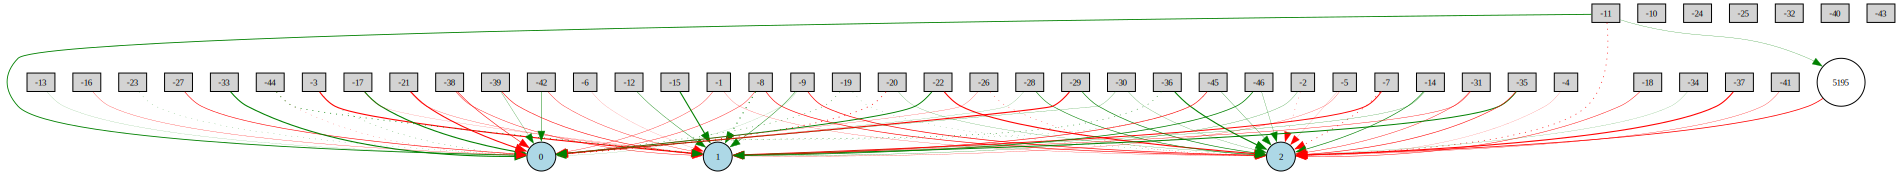

In [41]:
draw_net(config, winner1)

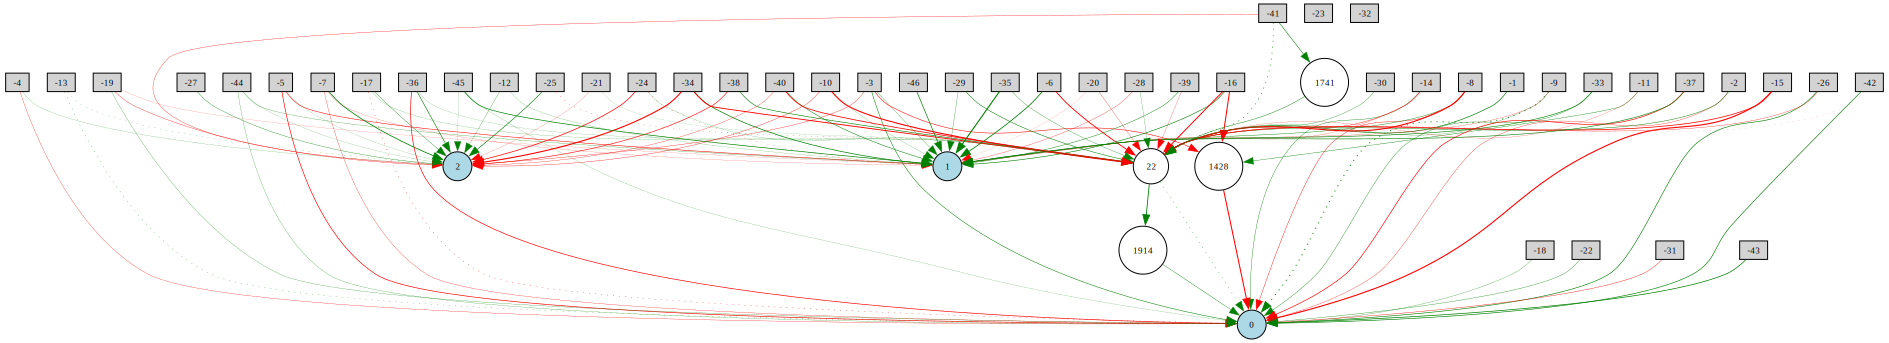

In [42]:
draw_net(config, winner2)

In [10]:
def print_genome_structure(genome):
    print(f"Genome ID: {genome.key}")
    
    # Print nodes
    print("\nNodes:")
    for node_id, node in genome.nodes.items():
        print(f"  Node {node_id}: {node}")
    
    # Print connections
    print("\nConnections:")
    for connection in genome.connections.values():
        print(f" {connection}")

In [11]:
print_genome_structure(winner1)

Genome ID: 24461

Nodes:
  Node 0: DefaultNodeGene(key=0, bias=-2.2792369259197662, response=1.0, activation=neat_sigmoid, aggregation=sum)
  Node 1: DefaultNodeGene(key=1, bias=1.3765709469963012, response=1.0, activation=neat_sigmoid, aggregation=sum)
  Node 2: DefaultNodeGene(key=2, bias=-0.4938791466388738, response=1.0, activation=neat_sigmoid, aggregation=sum)
  Node 5195: DefaultNodeGene(key=5195, bias=-0.399270873405805, response=1.0, activation=neat_sigmoid, aggregation=sum)

Connections:
 DefaultConnectionGene(key=(-22, 0), weight=4.2529643583531795, enabled=True)
 DefaultConnectionGene(key=(-42, 1), weight=-1.3362219708366077, enabled=True)
 DefaultConnectionGene(key=(-17, 0), weight=5.0, enabled=True)
 DefaultConnectionGene(key=(-14, 2), weight=2.6598429841199365, enabled=True)
 DefaultConnectionGene(key=(-31, 1), weight=-1.431423384667177, enabled=True)
 DefaultConnectionGene(key=(-19, 2), weight=0.5903207180036821, enabled=False)
 DefaultConnectionGene(key=(-4, 2), weight

In [12]:
print_genome_structure(winner2)

Genome ID: 8534

Nodes:
  Node 0: DefaultNodeGene(key=0, bias=3.48559604923022, response=1.0, activation=neat_sigmoid, aggregation=sum)
  Node 1: DefaultNodeGene(key=1, bias=0.43060419227499935, response=1.0, activation=neat_sigmoid, aggregation=sum)
  Node 2: DefaultNodeGene(key=2, bias=1.878353511517838, response=1.0, activation=neat_sigmoid, aggregation=sum)
  Node 22: DefaultNodeGene(key=22, bias=-2.8421535298338716, response=1.0, activation=neat_sigmoid, aggregation=sum)
  Node 1428: DefaultNodeGene(key=1428, bias=1.5936892613306322, response=1.0, activation=neat_sigmoid, aggregation=sum)
  Node 1741: DefaultNodeGene(key=1741, bias=-0.836973052482928, response=1.0, activation=neat_sigmoid, aggregation=sum)
  Node 1914: DefaultNodeGene(key=1914, bias=-1.622232064644547, response=1.0, activation=neat_sigmoid, aggregation=sum)

Connections:
 DefaultConnectionGene(key=(-14, 22), weight=-1.4534337149949388, enabled=True)
 DefaultConnectionGene(key=(-45, 2), weight=0.12763531423246588, 

## Regularizations

### Weights 

In [38]:
weight_penality = 0
for c in winner1.connections:
    if c in winner2.connections:
        weight_penality += (winner1.connections[c].weight - winner2.connections[c].weight) **2
        # print(winner1.connections[c].weight, winner2.connections[c].weight, "Connection", c, "is in both genomes")
wieght_lambda = 0.005
weight_penality, wieght_lambda * weight_penality

(338.8781771003055, 1.6943908855015275)

### Genomic distance

An approximate measure of the difference between genomes, used in dividing the population into species.

In [31]:
config.compatibility_weight_coefficient = 0.6
config.compatibility_disjoint_coefficient = 1.0
distance_lambda = 0.5
distance_penalty = winner1.distance(winner2, config)
distance_penalty, distance_lambda * distance_penalty

(3.0951156521497856, 1.5475578260748928)

### Innovation Difference

The symmetric_difference() method returns a set that contains all items from both set, but not the items that are present in both sets. Meaning: The returned set contains a mix of items that are not present in both sets.

In [34]:
def innovation_difference(genome1, genome2):
    diff = 0
    
    # Compare connections
    genome1_conn_innovations = set(gene.key for gene in genome1.connections.values())
    genome2_conn_innovations = set(gene.key for gene in genome2.connections.values())
    
    conn_diff = len(genome1_conn_innovations.symmetric_difference(genome2_conn_innovations))
    diff += conn_diff
    # print("Connection diff", conn_diff)
    # Compare nodes
    genome1_node_innovations = set(gene.key for gene in genome1.nodes.values())
    genome2_node_innovations = set(gene.key for gene in genome2.nodes.values())
    
    node_diff = len(genome1_node_innovations.symmetric_difference(genome2_node_innovations))
    diff += node_diff
    # print("Node diff", node_diff)
    return diff

innovation_lambda = 0.01
innovation_penalty = innovation_difference(winner1, winner2)
innovation_penalty, innovation_lambda * innovation_penalty

(112, 1.12)

### Fitness after regularization

In [40]:
print(winner2.fitness)
winner2.fitness - (wieght_lambda * weight_penality + distance_lambda * distance_penalty + innovation_lambda * innovation_penalty)

9.0


4.638051288423579